In [19]:
!pip install psynlig

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from psynlig import (
    pca_explained_variance,
    pca_explained_variance_bar,
)

In [21]:
# Read the CSV for listings
listing_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1mn47Wp7mbaiXxWjIDw3xQR3k1udXtxxu')

#**Listing EDA and Preprocessing**

In [22]:
listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37784 entries, 0 to 37783
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              37784 non-null  int64  
 1   name                            37782 non-null  object 
 2   host_id                         37784 non-null  int64  
 3   host_name                       37778 non-null  object 
 4   neighbourhood_group             37784 non-null  object 
 5   neighbourhood                   37784 non-null  object 
 6   latitude                        37784 non-null  float64
 7   longitude                       37784 non-null  float64
 8   room_type                       37784 non-null  object 
 9   price                           22969 non-null  float64
 10  minimum_nights                  37784 non-null  int64  
 11  number_of_reviews               37784 non-null  int64  
 12  last_review                     

In [23]:
listing_data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,3.778400e+04,3.778400e+04,37784.000000,37784.000000,22969.000000,37784.000000,37784.000000,25892.000000,37784.000000,37784.000000,37784.000000
mean,4.132488e+17,1.698767e+08,40.728805,-73.947311,195.224128,28.882172,25.658639,0.866954,71.636354,163.400963,3.731447
std,4.911855e+17,1.850207e+08,0.056120,0.054543,353.251037,29.905150,62.619846,1.885964,224.585038,148.521232,18.798642
min,2.595000e+03,1.678000e+03,40.500366,-74.251907,8.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.132202e+07,1.747741e+07,40.688662,-73.983316,82.000000,30.000000,0.000000,0.090000,1.000000,0.000000,0.000000
50%,4.998368e+07,8.703937e+07,40.726379,-73.954930,132.000000,30.000000,3.000000,0.290000,2.000000,155.000000,0.000000
75%,8.897044e+17,3.052402e+08,40.762310,-73.928196,223.000000,30.000000,22.000000,1.000000,9.000000,329.000000,1.000000
max,1.325354e+18,6.691812e+08,40.911390,-73.713650,20000.000000,1250.000000,2485.000000,116.300000,1154.000000,365.000000,1779.000000


In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

test_listing = listing_data.drop(['host_id', 'id', 'name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'last_review', 'license'], axis=1)

# Identify categorical and numerical columns
categorical_cols = test_listing.select_dtypes(include=['object']).columns
numerical_cols = test_listing.select_dtypes(include=['float64', 'int64']).columns

# Define transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

# Apply transformation
transformed_data = preprocessor.fit_transform(test_listing)

# Get feature names
encoded_cat_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Convert back to DataFrame
listings_encoded = pd.DataFrame(transformed_data, columns=final_columns)
listings_encoded.head()

,room_type_Hotel room,room_type_Private room,room_type_Shared room,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,0.0,0.0,0.0,40.75356,-73.98559,240.0,30.0,49.0,0.27,3.0,365.0,0.0
1,0.0,0.0,0.0,40.70935,-73.95342,81.0,30.0,195.0,1.03,1.0,196.0,4.0
2,0.0,1.0,0.0,40.80107,-73.94255,65.0,30.0,1.0,0.03,2.0,83.0,0.0
3,0.0,1.0,0.0,40.78778,-73.94759,70.0,30.0,251.0,1.36,1.0,8.0,5.0
4,0.0,1.0,0.0,40.71248,-73.95881,NaN,30.0,13.0,0.07,2.0,0.0,0.0


In [25]:
from sklearn.linear_model import LinearRegression

regression_data = listings_encoded.dropna(subset=['price'])

# Create features and target
x = regression_data[['latitude', 'longitude', 'room_type_Hotel room','room_type_Private room','room_type_Shared room']]
y = regression_data['price']

# Fit linear regression model
model = LinearRegression()
model.fit(x, y)

# Create a new column with our predictions
listings_encoded.loc[:, 'price_predicted'] = model.predict(listings_encoded.loc[:, ['latitude', 'longitude', 'room_type_Hotel room','room_type_Private room','room_type_Shared room']])

listing_data['price'] = listing_data['price'].fillna(listings_encoded['price_predicted'])
listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37784 entries, 0 to 37783
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              37784 non-null  int64  
 1   name                            37782 non-null  object 
 2   host_id                         37784 non-null  int64  
 3   host_name                       37778 non-null  object 
 4   neighbourhood_group             37784 non-null  object 
 5   neighbourhood                   37784 non-null  object 
 6   latitude                        37784 non-null  float64
 7   longitude                       37784 non-null  float64
 8   room_type                       37784 non-null  object 
 9   price                           37784 non-null  float64
 10  minimum_nights                  37784 non-null  int64  
 11  number_of_reviews               37784 non-null  int64  
 12  last_review                     

**Categorical variables are:**

host_id, id, name, host_name, neighbourhood_group, neighbourhood, room_type, last_review, license

In [26]:
# Remove the categorical variables
numeric_listing = listing_data.drop(['host_id', 'id', 'name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review', 'license'], axis=1)

In [27]:
numeric_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37784 entries, 0 to 37783
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        37784 non-null  float64
 1   longitude                       37784 non-null  float64
 2   price                           37784 non-null  float64
 3   minimum_nights                  37784 non-null  int64  
 4   number_of_reviews               37784 non-null  int64  
 5   reviews_per_month               25892 non-null  float64
 6   calculated_host_listings_count  37784 non-null  int64  
 7   availability_365                37784 non-null  int64  
 8   number_of_reviews_ltm           37784 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 2.6 MB


In [28]:
# Addressing and correcting null values in reviews_per_month
# NaN because we are dviding 0 by a number
nulls_in_rpm = numeric_listing[numeric_listing['reviews_per_month'].isna()]
nulls_in_rpm['number_of_reviews'].value_counts()

,count
number_of_reviews,
0,11892


In [29]:
# Can fill the NaN with 0
numeric_listing['reviews_per_month'] = numeric_listing['reviews_per_month'].fillna(0)

In [30]:
numeric_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37784 entries, 0 to 37783
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        37784 non-null  float64
 1   longitude                       37784 non-null  float64
 2   price                           37784 non-null  float64
 3   minimum_nights                  37784 non-null  int64  
 4   number_of_reviews               37784 non-null  int64  
 5   reviews_per_month               37784 non-null  float64
 6   calculated_host_listings_count  37784 non-null  int64  
 7   availability_365                37784 non-null  int64  
 8   number_of_reviews_ltm           37784 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 2.6 MB


In [31]:
# The number of listings that do not have availability for the next year due to the owner blocking the lisiting or booked by a guest
numeric_listing[numeric_listing['availability_365'] == 0].count() # 12562
numeric_listing[numeric_listing['availability_365'] == 365].count() # 3663

,0
latitude,3663
longitude,3663
price,3663
minimum_nights,3663
number_of_reviews,3663
reviews_per_month,3663
calculated_host_listings_count,3663
availability_365,3663
number_of_reviews_ltm,3663


In [32]:
# Lets look into the number of listings that require a 30 night minimum stay
# Nearly 30088 have a 30 listing, likely due to Local Law 18
# Potential reason for no change from the other listings is that they are a hotel, motel, approved rooming house, or haven't been updated by the host

numeric_listing['minimum_nights'].value_counts()

,count
minimum_nights,
30,30088
1,2972
31,1489
2,918
3,710
...,...
89,1
370,1
96,1


<Axes: >

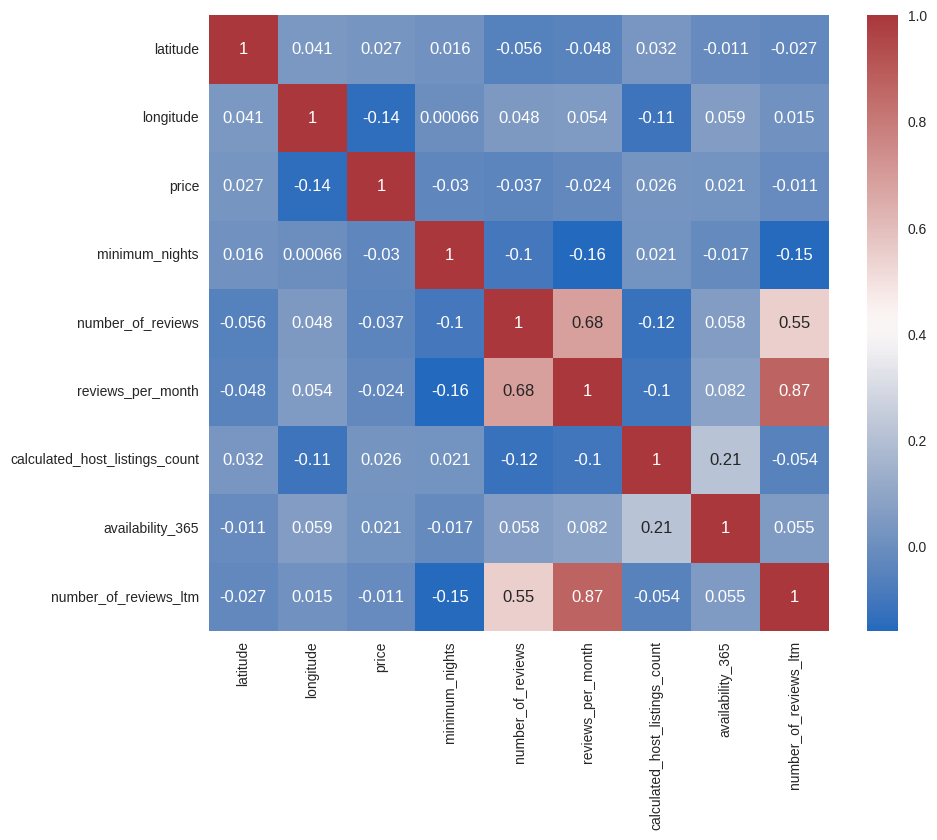

In [33]:
correlations = numeric_listing.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='vlag')

**Drop the following columns since they are redundant**

In [34]:
numeric_listing.drop(['reviews_per_month','calculated_host_listings_count'], axis=1, inplace=True)

In [35]:
numeric_listing.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,availability_365,number_of_reviews_ltm
count,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000
mean,40.728805,-73.947311,193.996562,28.882172,25.658639,163.400963,3.731447
std,0.056120,0.054543,278.804402,29.905150,62.619846,148.521232,18.798642
min,40.500366,-74.251907,8.000000,1.000000,0.000000,0.000000,0.000000
25%,40.688662,-73.983316,105.000000,30.000000,0.000000,0.000000,0.000000
50%,40.726379,-73.954930,150.000000,30.000000,3.000000,155.000000,0.000000
75%,40.762310,-73.928196,248.273162,30.000000,22.000000,329.000000,1.000000
max,40.911390,-73.713650,20000.000000,1250.000000,2485.000000,365.000000,1779.000000


#**Clustering**

##**Scale the Data and Run Kmeans**

In [36]:
# Preprocessing all of our data for kmean
sc = StandardScaler()

normalized_data = sc.fit_transform(numeric_listing)
df_normalized = pd.DataFrame(normalized_data, columns=numeric_listing.columns)

In [37]:
kmeans_model = KMeans(n_clusters=4, init='random')
kmean_results = kmeans_model.fit(df_normalized)

numeric_listing['cluster_kmeans'] = kmean_results.labels_

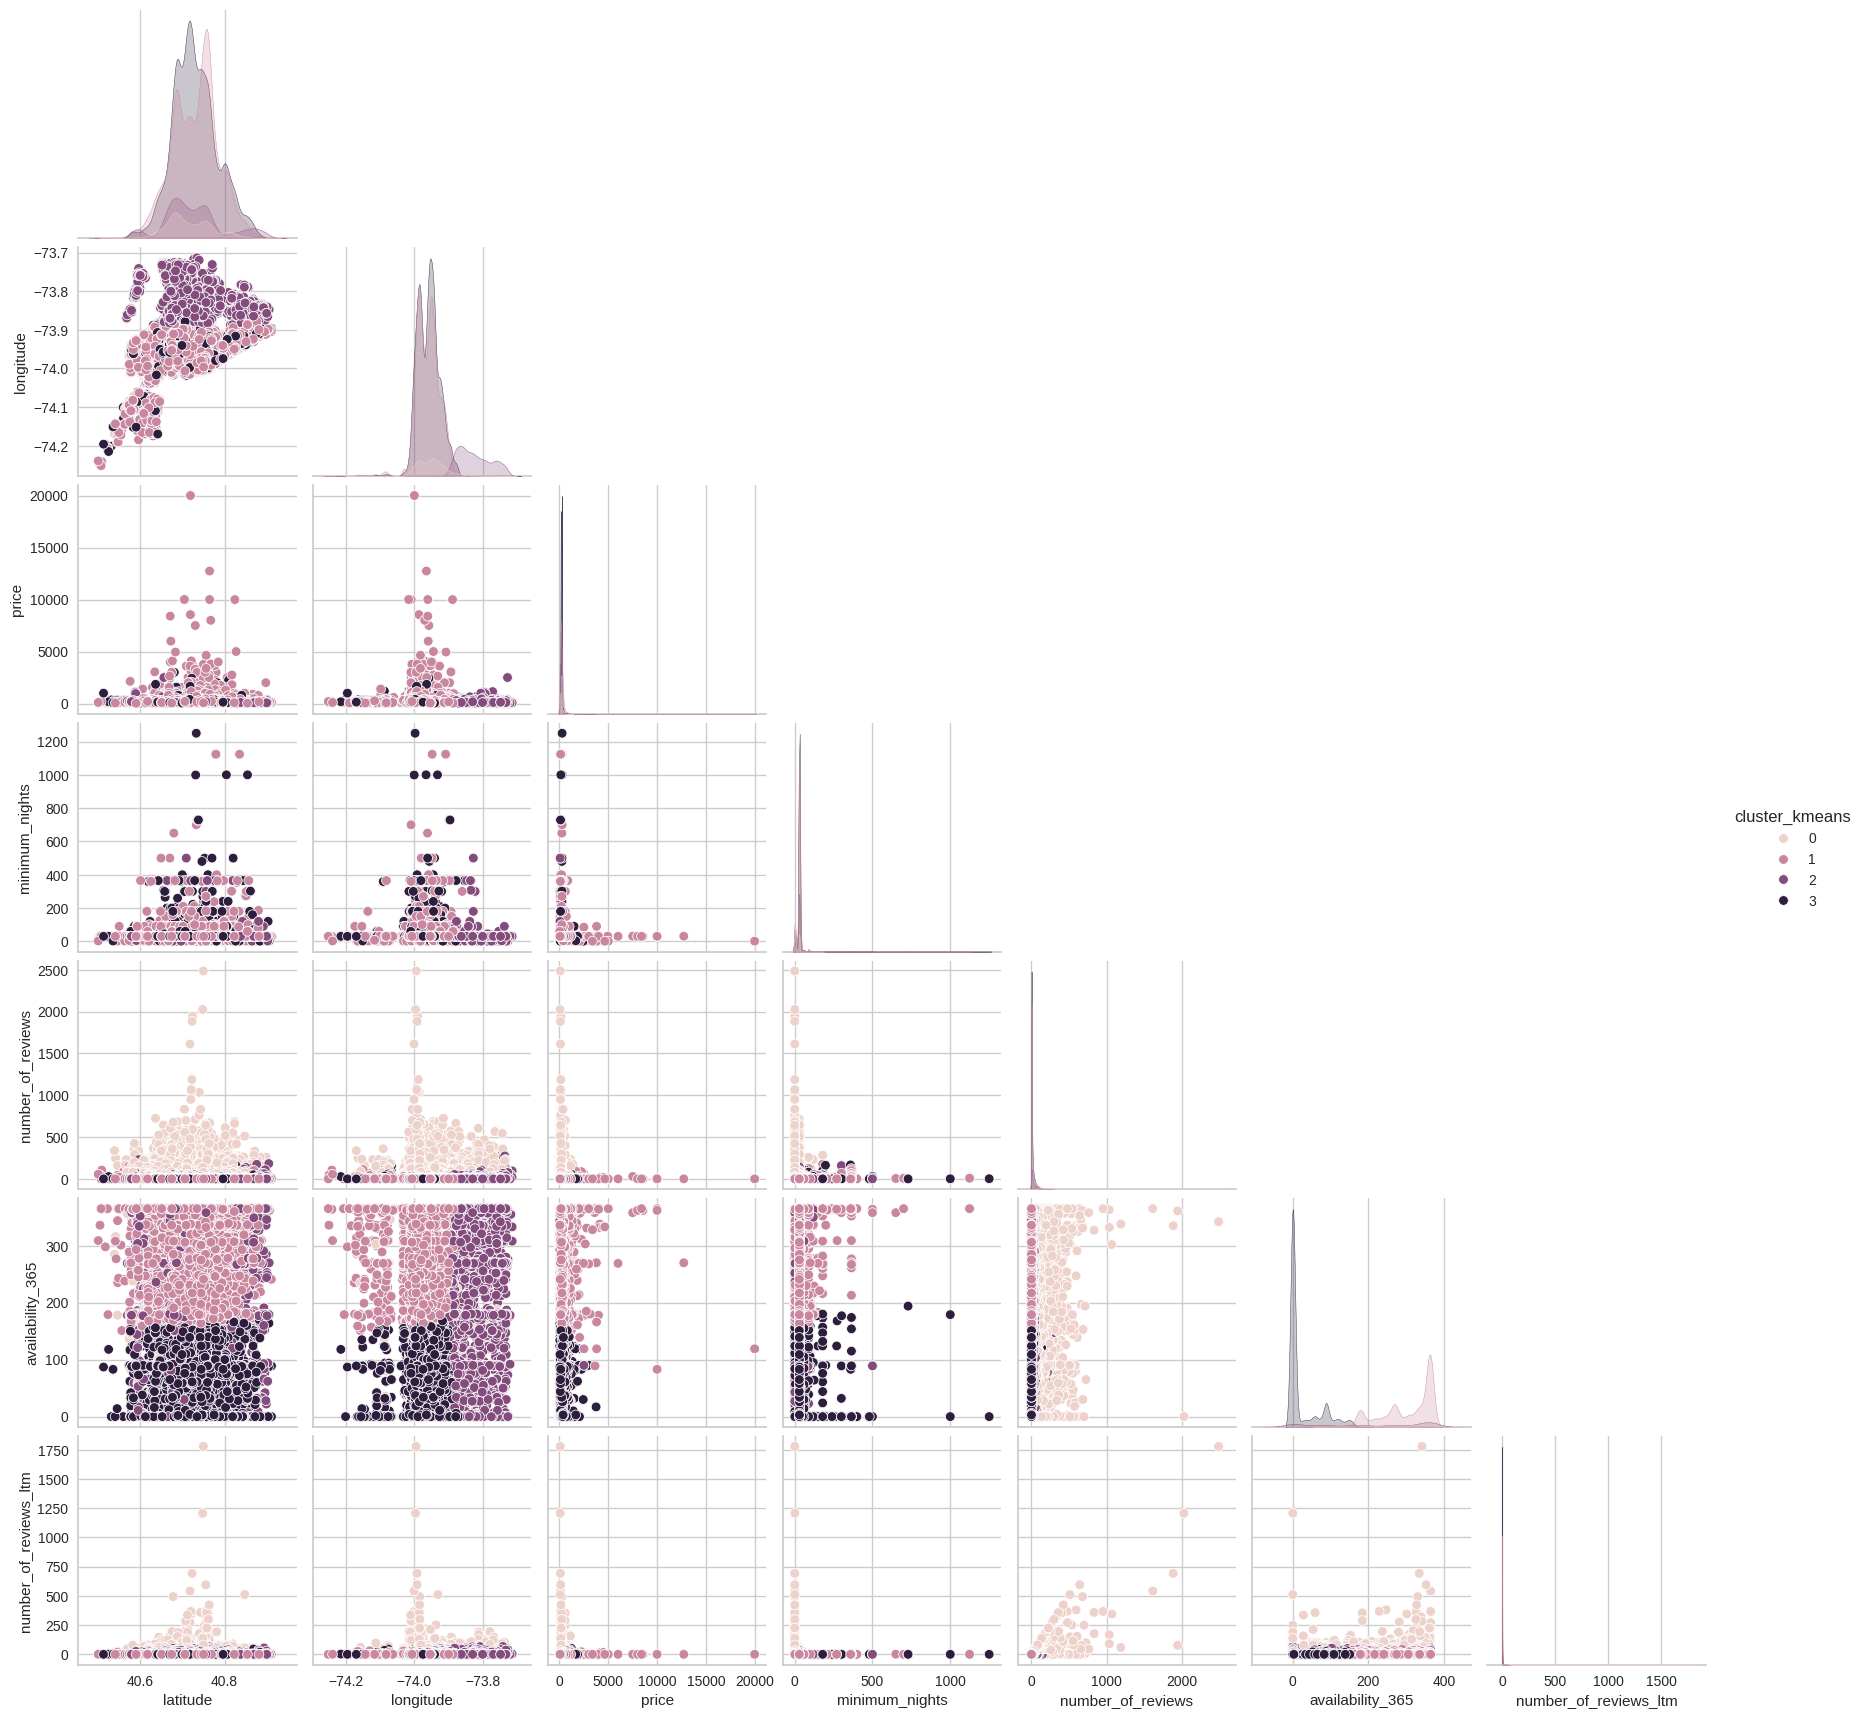

In [38]:
# Pairplots
sns.pairplot(numeric_listing, hue='cluster_kmeans', corner=True)

##**Elbow Test and Silhouette Score**

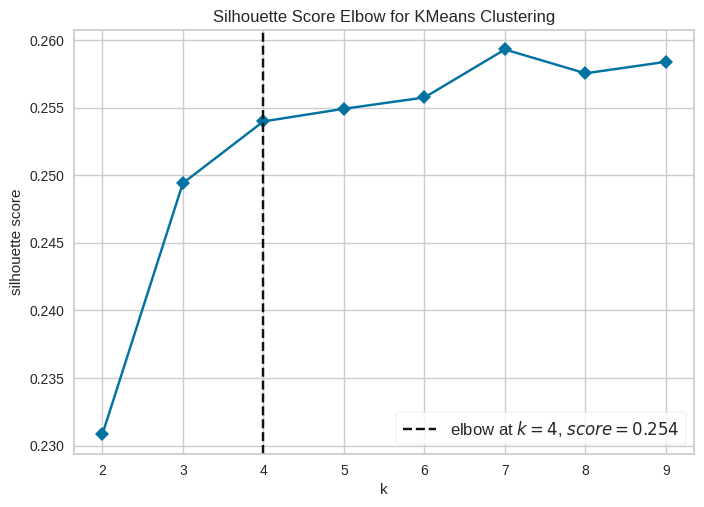

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [39]:
visualizer = KElbowVisualizer(kmeans_model, k=(2,10), metric="silhouette", timings=False)
visualizer.fit(df_normalized)
visualizer.show()

/usr/local/lib/python3.11/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.11/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


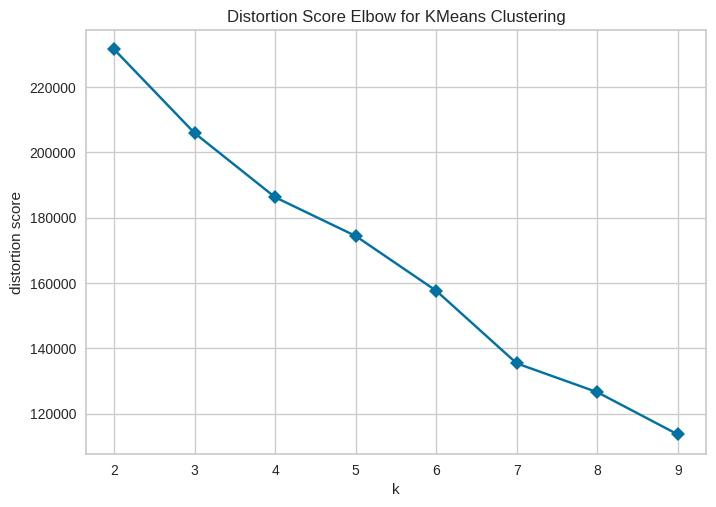

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
visualizer = KElbowVisualizer(kmeans_model, k=(2,10), metric="distortion", timings=False)
visualizer.fit(df_normalized)
visualizer.show()

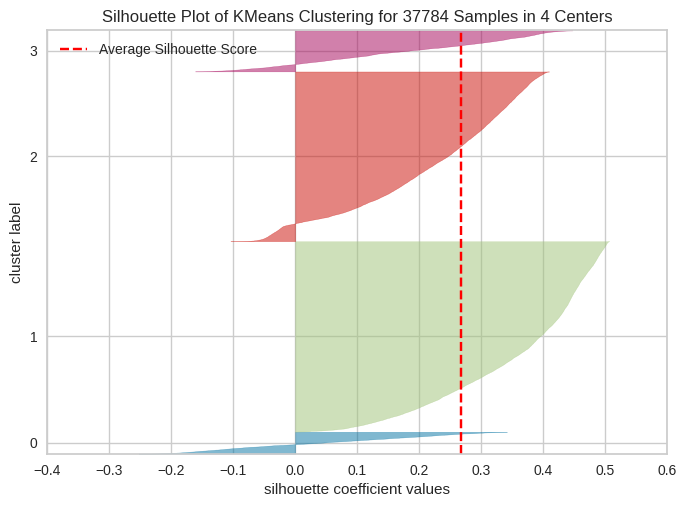

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 37784 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [41]:
kmeans_model = KMeans(4,init='random')
visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick', timings=False)
visualizer.fit(df_normalized)
visualizer.show()

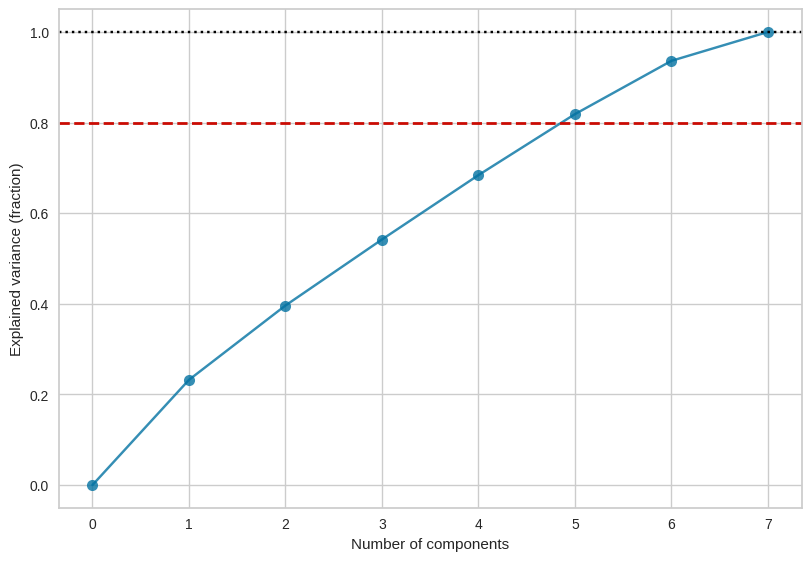

In [42]:
# Create the model
model = PCA()

#fit the data
model.fit(normalized_data)

# transform the data
transformed_data = model.transform(normalized_data)
transformed_data_df = pd.DataFrame(transformed_data)

# Rename the columns
transformed_data_df.columns = [f"PC{i+1}" for i in range(transformed_data_df.shape[1])]

_, ax = pca_explained_variance(model,  marker='o', markersize=8, alpha=0.8)

# Let's add a line at an explained variance of 90%
ax.axhline(y=0.80, color='r', linestyle='--', linewidth=2)

plt.show()

In [45]:
components_df = pd.DataFrame(model.components_)

# Rename the columns
components_df.columns = numeric_listing.columns[:7]

# Rename the rows
components_df.index = [f"PC{i+1}" for i in range(components_df.shape[0])]

components_df

loadings = components_df.mul(np.sqrt(model.explained_variance_), axis=0)

loadings_df = pd.DataFrame(loadings)
loadings_df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,availability_365,number_of_reviews_ltm
PC1,-0.120812,0.109985,-0.071846,-0.349362,0.844878,0.173618,0.852889
PC2,0.107234,0.747758,-0.709959,0.223862,-0.000243,0.133544,-0.076289
PC3,0.694995,0.207389,0.387389,-0.138217,-0.059553,0.566791,-0.008665
PC4,-0.638561,-0.001420,0.088568,0.109981,-0.072475,0.740405,-0.116684
PC5,0.163482,-0.190196,0.093867,0.883955,0.240275,0.048379,0.169812
